In [17]:
import os
import random

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K

import tensorflow as tf

In [18]:
import pandas as pd, numpy as np
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [5]:
pip install efficientnet albumentations

     |████████████████████████████████| 72 kB 870 kB/s eta 0:00:011
     |████████████████████████████████| 29.2 MB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 948 kB 64.0 MB/s eta 0:00:01
     |████████████████████████████████| 37.6 MB 73.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 95.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 66.4 MB/s eta 0:00:01
     |████████████████████████████████| 50.4 MB 69.1 MB/s eta 0:00:01
     |████████████████████████████████| 161 kB 73.9 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 12.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [23]:
! unzip test_images.zip

Archive:  test_images.zip
   creating: test_images/
  inflating: test_images/test_1305.jpg  
  inflating: test_images/test_0409.jpg  
  inflating: test_images/test_0503.jpg  
  inflating: test_images/test_0478.jpg  
  inflating: test_images/test_0206.jpg  
  inflating: test_images/test_0680.jpg  
  inflating: test_images/test_0838.jpg  
  inflating: test_images/test_0128.jpg  
  inflating: test_images/test_1612.jpg  
  inflating: test_images/test_1075.jpg  
  inflating: test_images/test_1031.jpg  
  inflating: test_images/test_0641.jpg  
  inflating: test_images/test_0758.jpg  
  inflating: test_images/test_1373.jpg  
  inflating: test_images/test_0578.jpg  
  inflating: test_images/test_1608.jpg  
  inflating: test_images/test_0014.jpg  
  inflating: test_images/test_1403.jpg  
  inflating: test_images/test_1123.jpg  
  inflating: test_images/test_0451.jpg  
  inflating: test_images/test_0130.jpg  
  inflating: test_images/test_1518.jpg  
  inflating: test_images/test_1374.jpg  
  inf

# データの読み込み

In [24]:
all_image_paths = files_train
all_image_labels = df_train.class_num

files_train = tf.io.gfile.glob(['./train_images/{}'.format(x) for x in df_train.id])
labels_train = [int(x) for x in df_train.class_num]

NameError: name 'files_train' is not defined

In [25]:
df_train = pd.read_csv("train_images.csv")
df_test = pd.read_csv("test_images.csv")
df = pd.concat([df_train, df_test]).reset_index(drop = True)

df_image_id = df.id
df_class = df.class_num

In [26]:
df = pd.concat([df_train, df_test]).reset_index(drop = True)

# 各種設定

In [27]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [384,384,384,384,384]

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [32]*FOLDS
EPOCHS = [12]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [6,6,6,6,6]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

In [28]:
DATADIR_TRAIN = "./train_images/"
DATADIR_TEST = "./test_images/"

In [29]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    
# AUTOTUNEはGPUの処理とCPUの処理の配分を動的に設定してくれるパラメータ
AUTOTUNE     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


In [30]:
from albumentations.core.transforms_interface import ImageOnlyTransform

def resize_square(img):
    """長辺のサイズで正方形の画像に"""
    l=max(img.shape[:2])
    
    h,w = img.shape[:2]
    hm = (l-h)//2
    wm = (l-w)//2
    return cv2.copyMakeBorder(img,
                            hm,
                            hm+(l-h)%2,
                            wm,
                            wm+(l-w)%2,
                            cv2.BORDER_CONSTANT,
                            value=0)

In [31]:
class CropLemon(ImageOnlyTransform):
    """レモンが写っている部分をcrop"""

    def __init__(self, margin=10, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.margin = margin

    def get_box(self, img):
        """ 中央に近い黄色い領域を見つける """
        h, s, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))

        # h,v のしきい値で crop
        _, img_hcrop = cv2.threshold(h, 0, 40, cv2.THRESH_BINARY)
        _, img_vcrop = cv2.threshold(v, v.mean(), 255, cv2.THRESH_BINARY)
        th_img = (img_hcrop * (img_vcrop / 255)).astype(np.uint8)

        contours, hierarchy = \
            cv2.findContours(th_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        # サイズの大きいものだけ選択
        contours = [c for c in contours if cv2.contourArea(c) > 10000]
        if not contours: return None

        # 中央に近いものを選択
        center = np.array([img.shape[1] / 2, img.shape[0] / 2])  # w, h
        min_contour = None
        min_dist = 1e10

        for c in contours:
            tmp = np.array(c).reshape(-1, 2)
            m = tmp.mean(axis=0)
            dist = sum((center - m) ** 2)
            if dist < min_dist:
                min_contour = tmp
                min_dist = dist

        box = [
            *(min_contour.min(axis=0) - self.margin).astype(np.int).tolist(),
            *(min_contour.max(axis=0) + self.margin).astype(np.int).tolist()]
        for i in range(4):
            if box[i] < 0: box[i] = 0
            if i % 2 == 0:
                if box[i] > img.shape[1]: box[i] = img.shape[1]
            else:
                if box[i] > img.shape[0]: box[i] = img.shape[0]

        return box  # left, top, right, bottom

    def apply(self, image, **params):
        image = image.copy()
        box = self.get_box(image)
        crop_img = None
        if not box or (box[3] - box[1] < 50 or box[2] - box[0] < 50):
            pass
        else:
            try:
                crop_img = image[box[1]:box[3], box[0]:box[2]]
            except:
                pass
        if crop_img is None:
            crop_img = image[40:, 10:-20]
        return resize_square(crop_img)

    def get_transform_init_args_names(self):
        return ("margin",)

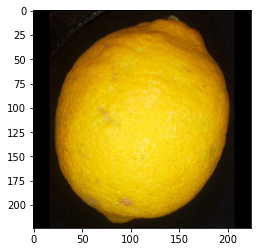

In [32]:
img = cv2.imread('train_images/train_0300.jpg')
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
crop_img = CropLemon()(image=img)['image']
crop_img = cv2.resize(crop_img, (224, 224)) 
plt.imshow(crop_img)

In [33]:
def get_file(path1, path2, files, img_arrays=[], labels=[]):
    num = 1
    ids = files["id"]
    classes = files.class_num
    for file in ids:
        if num <= 1102:
            print("{}/{}".format(num, len(df_image_id)))
            img = cv2.imread(DATADIR_TRAIN+file)
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            crop_img = CropLemon()(image=img)['image']
            img_array = cv2.resize(crop_img, (224, 224))  # 画像のリサイズ
            img_arrays.append(img_array)
            num += 1
        elif num > 1102:
            print("{}/{}".format(num, len(df_image_id)))
            img = cv2.imread(DATADIR_TEST+file)
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            crop_img = CropLemon()(image=img)['image']
            img_array = cv2.resize(crop_img, (224, 224))  # 画像のリサイズ
            img_arrays.append(img_array)
            num += 1
            
    for label in classes:
        labels.append(label)
    
    return img_arrays, labels

In [34]:
img_arrays, labels = get_file(DATADIR_TRAIN, DATADIR_TEST, df)

1/2753
2/2753
3/2753
4/2753
5/2753
6/2753
7/2753
8/2753
9/2753
10/2753
11/2753
12/2753
13/2753
14/2753
15/2753
16/2753
17/2753
18/2753
19/2753
20/2753
21/2753
22/2753
23/2753
24/2753
25/2753
26/2753
27/2753
28/2753
29/2753
30/2753
31/2753
32/2753
33/2753
34/2753
35/2753
36/2753
37/2753
38/2753
39/2753
40/2753
41/2753
42/2753
43/2753
44/2753
45/2753
46/2753
47/2753
48/2753
49/2753
50/2753
51/2753
52/2753
53/2753
54/2753
55/2753
56/2753
57/2753
58/2753
59/2753
60/2753
61/2753
62/2753
63/2753
64/2753
65/2753
66/2753
67/2753
68/2753
69/2753
70/2753
71/2753
72/2753
73/2753
74/2753
75/2753
76/2753
77/2753
78/2753
79/2753
80/2753
81/2753
82/2753
83/2753
84/2753
85/2753
86/2753
87/2753
88/2753
89/2753
90/2753
91/2753
92/2753
93/2753
94/2753
95/2753
96/2753
97/2753
98/2753
99/2753
100/2753
101/2753
102/2753
103/2753
104/2753
105/2753
106/2753
107/2753
108/2753
109/2753
110/2753
111/2753
112/2753
113/2753
114/2753
115/2753
116/2753
117/2753
118/2753
119/2753
120/2753
121/2753
122/2753
123/2753
1

(<matplotlib.image.AxesImage at 0x7f1fcd3c4c10>, Text(0.5, 1.0, '2.0'))

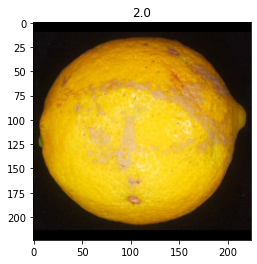

In [35]:
plt.imshow(img_arrays[30]), plt.title(labels[30])

# Tensorflowを使ったデータセットの作製

In [36]:
# 正規化
x_train = img_arrays[:1102]
x_test = img_arrays[1102:]
y_train = labels[:1102]
y_test = labels[1102:]

x_train = np.asarray(x_train) / 255.
x_test = np.asarray(x_test) / 255.
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

(<matplotlib.image.AxesImage at 0x7f1fccca8b90>, Text(0.5, 1.0, '1.0'))

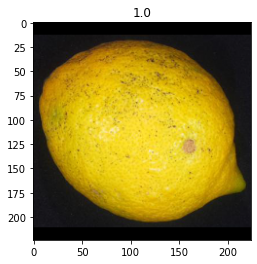

In [37]:
plt.imshow(x_train[10]), plt.title(y_train[10])

In [38]:
batch_size=32
input_size = (224, 224)

In [39]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.1, #10 for validation 
    rotation_range=360,
    zca_whitening=True,
    zca_epsilon=1e-06,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    shear_range=0.1,
#     zoom_range=[0.5,1.0],
    #channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=None,
    )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.1)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [40]:
train_generator = train_datagen.flow(x_train, 
                                               y_train, 
                                               batch_size = 32
                                              )

valid_generator = valid_datagen.flow(
                                               x_train, 
                                               y_train, 
                                               batch_size = 32)

In [41]:
batch1, batch2 = train_generator.next()

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [42]:
df_train.class_num = df_train.astype("str")

In [43]:
batch1.shape

(32, 224, 224, 3)

In [44]:
df_train["class_num"] = df_train["class_num"].astype("str")

In [45]:
batch1 = train_generator.next()

In [46]:
batch1, batch2 =  train_generator.next()

In [47]:
batch1[0].shape

(224, 224, 3)

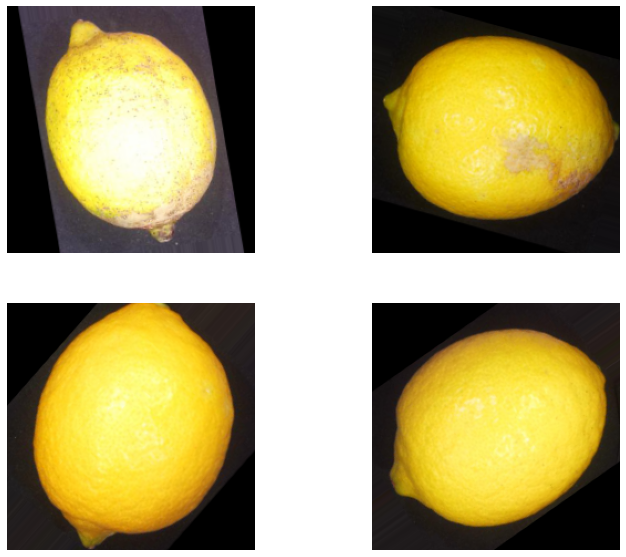

In [48]:
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    batch1,batch2 = train_generator.next()
    image = batch1[0]
    plt.imshow(image)
    plt.axis("off")
# show the figure
plt.show()

# データセットの作製

In [49]:
y_train.shape

(1102,)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model

from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.utils import plot_model, to_categorical
from keras.callbacks import TensorBoard

import tensorflow as tf

Using TensorFlow backend.


In [51]:
# モデルの定義

def CNN(x_train, y_train):
    visible = Input(shape=x_train.shape[1:])
    conv1 = Conv2D(32, kernel_size=4, activation='relu')(visible)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, kernel_size=4, activation='relu')(pool1)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
    flat = Flatten()(pool2)
    hidden1 = Dense(16, activation='relu')(flat)
    output = Dense(4, activation='softmax')(hidden1)
    model = Model(inputs=visible, outputs=output)

    adam = Adam(lr=1e-3)

    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    print(model.summary())

    return model

In [52]:
model_cnn = CNN(x_train, y_train)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 221, 221, 32)      1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 16)      8208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 44944)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                719120

In [144]:
history = model_cnn.fit(train_generator,
    validation_data = valid_generator,
    epochs=20, 
    verbose=1,
    steps_per_epoch = len(df_train)*0.9//batch_size,
    validation_steps = len(df_train)*0.1//batch_size )

Epoch 1/20
30/30 [==============================] - 19s 643ms/step - loss: 0.6231 - accuracy: 0.7845 - val_loss: 0.7301 - val_accuracy: 0.7292
Epoch 2/20
30/30 [==============================] - 20s 652ms/step - loss: 0.6295 - accuracy: 0.7824 - val_loss: 0.6355 - val_accuracy: 0.8229
Epoch 3/20
30/30 [==============================] - 20s 655ms/step - loss: 0.6553 - accuracy: 0.7813 - val_loss: 0.5029 - val_accuracy: 0.8438
Epoch 4/20
30/30 [==============================] - 20s 666ms/step - loss: 0.6593 - accuracy: 0.7792 - val_loss: 0.5702 - val_accuracy: 0.8021
Epoch 5/20
30/30 [==============================] - 23s 759ms/step - loss: 0.6099 - accuracy: 0.7983 - val_loss: 0.5623 - val_accuracy: 0.8021
Epoch 6/20
30/30 [==============================] - 22s 738ms/step - loss: 0.6320 - accuracy: 0.7813 - val_loss: 0.6891 - val_accuracy: 0.6979
Epoch 7/20
30/30 [==============================] - 20s 682ms/step - loss: 0.6002 - accuracy: 0.7962 - val_loss: 0.5855 - val_accuracy: 0.8021

In [145]:
pred = model_cnn.predict(x_test)
prediction =np.argmax(pred,axis=1)
df_pred = pd.DataFrame([prediction])

In [146]:
df_pred

,0,1,2,3,4,5,6,7,8,9,...,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650
0,0,3,0,3,0,1,0,1,2,0,...,0,1,1,1,0,1,2,1,0,0


In [150]:
pred_sam.head(6)

,test_0000.jpg,0
0,test_0001.jpg,3
1,test_0002.jpg,0
2,test_0003.jpg,3
3,test_0004.jpg,0
4,test_0005.jpg,0
5,test_0006.jpg,0


In [53]:
import efficientnet.tfkeras as efn

In [57]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]

# dim: 入力 df:どのefficientnetを使用するか class_num:分類するクラスの種類
def build_model(dim=224, ef=0, class_num=4):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    # Freeze the pretrained weights
    basetrainable = False
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = tf.keras.layers.Dense(class_num,activation='softmax')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [58]:
model = build_model()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 5124      
Total params: 4,054,688
Trainable params: 4,012,672
Non-trainable params: 42,016
_________________________________________________________________


In [86]:
history = model.fit(train_generator,
    validation_data = valid_generator,
    epochs=1, 
    verbose=1,
    steps_per_epoch = len(df_train)*0.9//batch_size,
    validation_steps = len(df_train)*0.1//batch_size )

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


30/30 [==============================] - 10s 317ms/step - loss: 0.0609 - accuracy: 0.9851 - val_loss: 0.3349 - val_accuracy: 0.9375


In [87]:
pred = model.predict(x_test)
prediction =np.argmax(pred,axis=1)
df_pred = pd.DataFrame([prediction])

In [97]:
model.evaluate(x_train,y_train)

35/35 [==============================] - 3s 57ms/step - loss: 0.1928 - accuracy: 0.9501


[0.1928388476371765, 0.950090765953064]

In [89]:
pred2 = pd.read_csv("sample_submit.csv", names=["photo", "class_num"])

In [99]:
df_pred

,0,1,2,3,4,5,6,7,8,9,...,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650
0,0,3,0,3,0,0,0,3,3,1,...,0,3,1,1,0,1,1,2,0,0


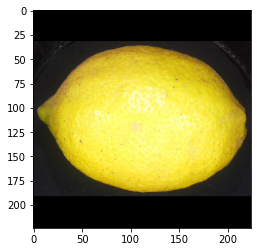

In [96]:
plt.imshow(x_test[22])

In [92]:
count = 0
for i in range(len(pred2.class_num)):
    if pred2.class_num[i] == df_pred[i][0]:
        count += 1
    else:
        print("{}がちがう cnnの予想は{}, efnの予想は{}".format(i, pred2.class_num[i], df_pred[i][0]))
print("{}%".format((count/len(pred2.class_num))*100))

7がちがう cnnの予想は2, efnの予想は3
9がちがう cnnの予想は3, efnの予想は1
16がちがう cnnの予想は0, efnの予想は2
18がちがう cnnの予想は1, efnの予想は2
22がちがう cnnの予想は2, efnの予想は1
23がちがう cnnの予想は3, efnの予想は1
36がちがう cnnの予想は2, efnの予想は1
37がちがう cnnの予想は2, efnの予想は1
39がちがう cnnの予想は0, efnの予想は2
44がちがう cnnの予想は2, efnの予想は1
46がちがう cnnの予想は0, efnの予想は1
54がちがう cnnの予想は0, efnの予想は3
58がちがう cnnの予想は0, efnの予想は2
60がちがう cnnの予想は3, efnの予想は1
61がちがう cnnの予想は0, efnの予想は2
64がちがう cnnの予想は0, efnの予想は1
66がちがう cnnの予想は2, efnの予想は1
69がちがう cnnの予想は2, efnの予想は1
77がちがう cnnの予想は1, efnの予想は2
78がちがう cnnの予想は1, efnの予想は2
85がちがう cnnの予想は3, efnの予想は1
86がちがう cnnの予想は1, efnの予想は2
94がちがう cnnの予想は0, efnの予想は1
105がちがう cnnの予想は2, efnの予想は1
106がちがう cnnの予想は0, efnの予想は2
112がちがう cnnの予想は2, efnの予想は1
113がちがう cnnの予想は0, efnの予想は2
127がちがう cnnの予想は3, efnの予想は1
132がちがう cnnの予想は2, efnの予想は1
133がちがう cnnの予想は0, efnの予想は1
137がちがう cnnの予想は0, efnの予想は2
138がちがう cnnの予想は1, efnの予想は2
140がちがう cnnの予想は2, efnの予想は1
150がちがう cnnの予想は0, efnの予想は1
152がちがう cnnの予想は2, efnの予想は1
153がちがう cnnの予想は0, efnの予想は1
158がちがう cnnの予想は0, efnの予想は1
180がちがう cnnの予想は0, efnの予想は1

In [98]:
df_test['preds']=df_pred

ValueError: Wrong number of items passed 1651, placement implies 1

In [100]:
df_test

,id
0,test_0000.jpg
1,test_0001.jpg
2,test_0002.jpg
3,test_0003.jpg
4,test_0004.jpg
...,...
1646,test_1646.jpg
1647,test_1647.jpg
1648,test_1648.jpg
1649,test_1649.jpg


In [101]:
k = [df_pred[i][0] for i in range(len(pred2.class_num))]

In [103]:
len(k)

1651

In [104]:
df_test["preds"] = k

In [105]:
df_test

,id,preds
0,test_0000.jpg,0
1,test_0001.jpg,3
2,test_0002.jpg,0
3,test_0003.jpg,3
4,test_0004.jpg,0
...,...,...
1646,test_1646.jpg,1
1647,test_1647.jpg,1
1648,test_1648.jpg,2
1649,test_1649.jpg,0


In [106]:
df_test.to_csv("submit_efn.csv", index = False, header = None)

In [107]:
dfdf = pd.read_csv("submit_efn.csv")